<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


## Resolución

###Alumna: Maria Fabiana Cid

###Librerias

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import re

### Datos
Utilizaremos como dataset el libro Las Mil y una Noches extraido en pdf de texto.info

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install PyMuPDF

import fitz  # PyMuPDF

pdf_path = "/content/drive/MyDrive/Anonimo - Las Mil y Una Noches.pdf"

doc = fitz.open(pdf_path)
corpus_text = ""

for page in doc:
    corpus_text += page.get_text()

print(corpus_text[:1000])  # Ver los primeros caracteres


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 59.7 MB/s eta 0:00:00
1
Las Mil y Una Noches
Anónimo
textos.info
Libros gratis - biblioteca digital abierta
2
Texto núm. 4140
Título: Las Mil y Una Noches
Autor: Anónimo
Etiquetas: Cuento
Editor: Edu Robsy
Fecha de creación: 24 de diciembre de 2018
Fecha de modificación: 27 de diciembre de 2018
Edita textos.info
Maison Carrée
c/ Ramal, 48
07730 Alayor - Menorca
Islas Baleares
España
Más textos disponibles en http://www.textos.info
3
Una palabra del traductor a sus amigos
Yo ofrezco
desnudas, vírgenes, intactas y sencillas,
para mis delicias y el placer de mis amigos,
estas noches árabes vividas, soñadas y traducidas sobre su tierra natal y 
sobre el agua
Ellas me fueron dulces durante los ocios en remotos mares, bajo un cielo 
ahora lejano.
Por eso las doy.
Sencillas, sonrientes y llenas de ingenuidad, como la musulmana 
Schehrazada, su madre suculenta que las dió a luz en el misterio; 
fermentando con emoción en los brazos de un

In [ ]:
#  Parámetros clave
max_context_size = 30        # ventana de entrada
val_split = 0.1              # proporción de validación
embedding_dim = 32
lstm_units = 64
batch_size = 300
epochs = 10

In [ ]:
#  Preprocesamiento del corpus
corpus_text = corpus_text.lower()
corpus_text = re.sub(r'[^a-záéíóúüñ\s]', '', corpus_text)
chars_vocab = sorted(set(corpus_text))
vocab_size = len(chars_vocab)

In [ ]:
#  Mapas de caracteres <-> índices
char2idx = {ch: i for i, ch in enumerate(chars_vocab)}
idx2char = {i: ch for ch, i in char2idx.items()}

In [ ]:
#  Tokenizar texto completo
tokenized_text = [char2idx[c] for c in corpus_text]


In [ ]:
tokenized_text[:1000]

[0,
 13,
 2,
 20,
 1,
 14,
 10,
 13,
 1,
 26,
 1,
 22,
 15,
 2,
 1,
 15,
 16,
 4,
 9,
 6,
 20,
 0,
 2,
 15,
 32,
 15,
 10,
 14,
 16,
 0,
 21,
 6,
 25,
 21,
 16,
 20,
 10,
 15,
 7,
 16,
 0,
 13,
 10,
 3,
 19,
 16,
 20,
 1,
 8,
 19,
 2,
 21,
 10,
 20,
 1,
 1,
 3,
 10,
 3,
 13,
 10,
 16,
 21,
 6,
 4,
 2,
 1,
 5,
 10,
 8,
 10,
 21,
 2,
 13,
 1,
 2,
 3,
 10,
 6,
 19,
 21,
 2,
 0,
 0,
 21,
 6,
 25,
 21,
 16,
 1,
 15,
 33,
 14,
 1,
 0,
 21,
 30,
 21,
 22,
 13,
 16,
 1,
 13,
 2,
 20,
 1,
 14,
 10,
 13,
 1,
 26,
 1,
 22,
 15,
 2,
 1,
 15,
 16,
 4,
 9,
 6,
 20,
 0,
 2,
 22,
 21,
 16,
 19,
 1,
 2,
 15,
 32,
 15,
 10,
 14,
 16,
 0,
 6,
 21,
 10,
 18,
 22,
 6,
 21,
 2,
 20,
 1,
 4,
 22,
 6,
 15,
 21,
 16,
 0,
 6,
 5,
 10,
 21,
 16,
 19,
 1,
 6,
 5,
 22,
 1,
 19,
 16,
 3,
 20,
 26,
 0,
 7,
 6,
 4,
 9,
 2,
 1,
 5,
 6,
 1,
 4,
 19,
 6,
 2,
 4,
 10,
 32,
 15,
 1,
 1,
 5,
 6,
 1,
 5,
 10,
 4,
 10,
 6,
 14,
 3,
 19,
 6,
 1,
 5,
 6,
 1,
 0,
 7,
 6,
 4,
 9,
 2,
 1,
 5,
 6,
 1,
 14,
 16,
 5,
 10,
 7,
 10,
 

### Organizando y estructurando el dataset

In [ ]:
# Separar texto en entrenamiento y validación
num_val = int(len(tokenized_text) * val_split) // max_context_size
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]


In [ ]:
#  Crear ventanas de entrada y etiquetas
def make_sequences(text, context_size):
    X = []
    y = []
    for i in range(len(text) - context_size):
        X.append(text[i:i + context_size])
        y.append(text[i + context_size])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_text, max_context_size)
X_val, y_val = make_sequences(val_text, max_context_size)

In [ ]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [ ]:
# Callback para Perplejidad
class PerplexityCallback(keras.callbacks.Callback):
    def __init__(self, validation_data=None):
        super().__init__()
        self.validation_data = validation_data
        self.train_perplexities = []
        self.val_perplexities = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss')
        if train_loss is not None:
            train_perplexity = np.exp(train_loss)
            self.train_perplexities.append(train_perplexity)
            print(f'\n📘 Training Perplexity: {train_perplexity:.4f}')
            logs['perplexity'] = train_perplexity

        val_loss = logs.get('val_loss')
        if val_loss is not None:
            val_perplexity = np.exp(val_loss)
            self.val_perplexities.append(val_perplexity)
            print(f'📗 Validation Perplexity: {val_perplexity:.4f}')
            logs['val_perplexity'] = val_perplexity


In [ ]:
#  Modelo LSTM secuencial
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_context_size))
model.add(LSTM(lstm_units, dropout=0.1, return_sequences=False))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [ ]:
 # Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[PerplexityCallback(validation_data=(X_val, y_val))]
)


Epoch 1/10
20054/20060 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4849
📘 Training Perplexity: 4.4076
📗 Validation Perplexity: 4.5888
20060/20060 ━━━━━━━━━━━━━━━━━━━━ 132s 7ms/step - loss: 1.4849 - val_loss: 1.5236 - perplexity: 4.4076 - val_perplexity: 4.5888
Epoch 2/10
20057/20060 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4808
📘 Training Perplexity: 4.3939
📗 Validation Perplexity: 4.5879
20060/20060 ━━━━━━━━━━━━━━━━━━━━ 137s 6ms/step - loss: 1.4808 - val_loss: 1.5234 - perplexity: 4.3939 - val_perplexity: 4.5879
Epoch 3/10
20058/20060 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4782
📘 Training Perplexity: 4.3819
📗 Validation Perplexity: 4.5743
20060/20060 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - loss: 1.4782 - val_loss: 1.5205 - perplexity: 4.3819 - val_perplexity: 4.5743
Epoch 4/10
20058/20060 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4750
📘 Training Perplexity: 4.3714
📗 Validation Perplexity: 4.5611
20060/20060 ━━━━━━━━━━━━━━━━━━━━ 127s 6ms/step - loss: 1.4750 - val_loss: 1.5176 - perp

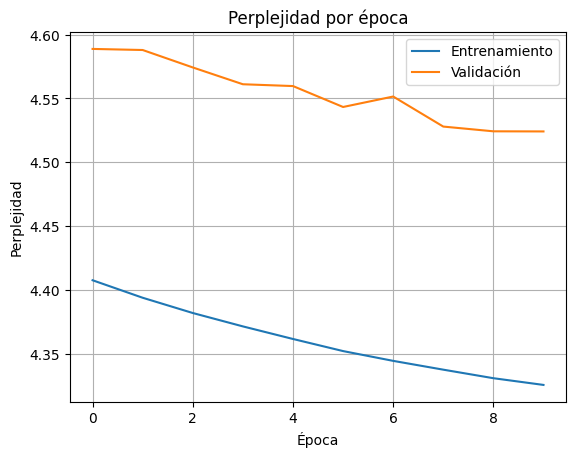

In [ ]:
import matplotlib.pyplot as plt

cb = history.history
train_perplexity = np.exp(cb['loss'])
val_perplexity = np.exp(cb['val_loss'])

plt.plot(train_perplexity, label="Entrenamiento")
plt.plot(val_perplexity, label="Validación")
plt.title("Perplejidad por época")
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.grid(True)
plt.legend()
plt.show()


Diferencia creciente entre entrenamiento y validación:
Aunque no es drástica, se empieza a abrir una brecha, lo cual puede ser una señal temprana de sobreajuste si el patrón continúa en más épocas.

### Generación de secuencias

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np




In [ ]:
def generate_seq(model, seed_text, max_length, n_chars):
    output_text = seed_text

    for _ in range(n_chars):
        encoded = [char2idx[ch] for ch in output_text.lower()[-max_length:] if ch in char2idx]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        prediction = model.predict(encoded, verbose=0)
        next_char_id = np.argmax(prediction[0])
        next_char = idx2char[next_char_id]

        output_text += next_char

    return output_text


In [ ]:
# Texto semilla
seed = "había una vez"
# Longitud del contexto
max_len = max_context_size
# Cuántos caracteres nuevos queremos generar
n_generate = 100

generated = generate_seq(model, seed, max_len, n_generate)
print(generated)


había una vez que le dijo en el mano de la cantar a la cabeza de la cabeza de la mano de la mano de la cara de la


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def sample_with_temperature(probabilities, temperature=1.0):
    """Muestrea un índice según distribución suavizada por temperatura."""
    probabilities = np.asarray(probabilities).astype('float64')
    probabilities = np.log(probabilities + 1e-10) / temperature
    exp_probs = np.exp(probabilities)
    probabilities = exp_probs / np.sum(exp_probs)
    return np.random.choice(len(probabilities), p=probabilities)

def generate_seq(model, seed_text, max_length, n_chars, temperature=1.0):
    """
    Genera texto carácter por carácter usando greedy o sampling con temperatura.

    Args:
        model (keras.Model): Modelo entrenado.
        seed_text (str): Texto inicial.
        max_length (int): Longitud máxima del contexto.
        n_chars (int): Cuántos caracteres generar.
        temperature (float): Si 0 o 1, greedy; si >1, más aleatorio.

    Returns:
        str: Texto generado.
    """
    output_text = seed_text

    for _ in range(n_chars):
        encoded = [char2idx.get(ch, 0) for ch in output_text.lower()[-max_length:]]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        prediction = model.predict(encoded, verbose=0)[0]

        if temperature == 1.0:
            next_char_id = np.argmax(prediction)
        else:
            next_char_id = sample_with_temperature(prediction, temperature)

        next_char = idx2char[next_char_id]
        output_text += next_char

    return output_text


In [ ]:
# Texto inicial
seed = "el califa"
max_len = max_context_size
n_generate = 300

# Modo determinista (greedy)
print("→ Greedy:")
print(generate_seq(model, seed, max_len, n_generate, temperature=1.0))

# Modo creativo (sampling)
print("\n→ Sampling (temp=0.8):")
print(generate_seq(model, seed, max_len, n_generate, temperature=0.8))

print("\n→ Sampling (temp=1.2):")
print(generate_seq(model, seed, max_len, n_generate, temperature=1.2))


→ Greedy:
el califa y le dijo en la carnero de la cabeza de la cara de la mano de la 
carcia de la mano de la cabeza de la mano de la cabeza de después de la carnera de la cabeza de la mano de la cara de la mano de la mano de la cabeza de la cabeza de la mano de la 
cara de la mano de la cabeza de la cabeza de la mano

→ Sampling (temp=0.8):
el califa a cortado a todos los mercadeos de los cogiendo por diwerte quedó la marchas y el sacar todo que venido deciunte los más hizo y 
por ospero estunado en los metientes de hassán levantar y fué tabde y en la 

cabezado estaba de ello que no asimos pero se residesero a su ese mundad en cuanto 
contró a

→ Sampling (temp=1.2):
el califa que sobra tierca la nozhe

y vista nunca poruviéndor 
momentones por una lámpo dijo a éscillo tievo dicioso derguras han taco de abulhene
con laas porque elcas ganemad aquí lunudalesposos mejillos lovare tal hiz que alistr y le dijo cofres suerte entonces es tío he otra lingues y tengíuno el jeique


Comentarios:

Al variar la temperatura en la generación de texto, se observa un claro trade-off entre coherencia y creatividad:

A temperaturas bajas (como greedy o 0.8), el modelo produce texto más estructurado y coherente, pero tiende a repetir frases y es poco expresivo.

A temperaturas más altas (como 1.2), el texto gana en diversidad y creatividad, pero pierde claridad y consistencia gramatical.

Por tanto, se podría probar conuna temperatura intermedia ( como por ej 1.0).

###  Beam search y muestreo aleatorio

In [ ]:
def generate_seq_stochastic_beam(model, seed_text, max_length, n_chars, beam_width=3):
    """
    Generación de texto con Beam Search Estocástico.

    Args:
        model (keras.Model): Modelo entrenado.
        seed_text (str): Texto inicial.
        max_length (int): Longitud máxima del contexto.
        n_chars (int): Número de caracteres a generar.
        beam_width (int): Tamaño del haz (cuántas secuencias se mantienen).

    Returns:
        str: Texto generado.
    """
    seed_seq = [char2idx.get(ch, 0) for ch in seed_text.lower()]
    sequences = [(seed_seq, 0.0, seed_text)]

    for _ in range(n_chars):
        all_candidates = []

        for seq, score, text_so_far in sequences:
            encoded = pad_sequences([seq[-max_length:]], maxlen=max_length, padding='pre')
            prediction = model.predict(encoded, verbose=0)[0]

            top_ids = np.argsort(prediction)[-beam_width:]
            top_probs = prediction[top_ids]
            top_probs = top_probs / np.sum(top_probs)

            sampled_idx = np.random.choice(top_ids, p=top_probs)
            new_seq = seq + [sampled_idx]
            new_score = score - np.log(prediction[sampled_idx] + 1e-10)
            new_text = text_so_far + idx2char[sampled_idx]

            all_candidates.append((new_seq, new_score, new_text))

        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_width]

    return sequences[0][2]


In [ ]:
seed = "había una vez "
max_len = max_context_size
n_generate = 300

print("→ Stochastic Beam Search:")
print(generate_seq_stochastic_beam(model, seed, max_len, n_generate, beam_width=3))


→ Stochastic Beam Search:
había una vez que el califa y está esta preganto y la 
palabro de mi corazón 
dormigo y el mercader y le hija del pronto
en los corazas
y de los cabalabado a lo carnero de la 
cierta de su 
por el manera de los contrarios de su madre de sego del procio 
entre mis calles y despecho y le 
caralente y le hice de mi 


El resultado muestra una buena diversidad creativa gracias al enfoque estocástico de Beam Search. Se generan secuencias que imitan estructuras narrativas del corpus, pero también aparecen errores gramaticales, invenciones léxicas y frases incoherentes, que son inherentes a este tipo de generación basada en caracteres. Aun así, el modelo capta cierta fluidez y puede beneficiarse de más entrenamiento y técnicas de muestreo más refinadas.

¿Cómo mejorar los resultados?
Entrenar más épocas: Más exposición al corpus ayuda al modelo a captar patrones más globales y coherentes.

Aumentar el corpus:  incluir más cuentos mejora el contexto.

Probar con beam_width más grande: Aumenta la calidad de selección.

Hacer sampling solo sobre top-k (top-k sampling): Para evitar palabras con probabilidad muy baja.

Probar distintos valores de temperatura

Aclaración: por limitaciones en el uso de la GPU, no se realizan más epocas.